## A notebook to perform PCA on EEG data
#### Shateesh Bhugwansing


### Emmanuil's preprocessing code (ICA) : 

In [17]:
%run ../preprocessing/Artifact_Removal/preprocecssing_helpers.ipynb
import os

import mne
from mne.preprocessing import ICA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (50.0, 30.0)
matplotlib.rcParams.update({'font.size': 15})

In [18]:
path = '/Volumes/SB/eegData_SETfiles/Stroop_EEG_Data_300s'
eeglab_files = os.listdir(path)

In [19]:
eeglab_dict = search_folders(path, eeglab_files)
eeglab_files = paths_of_eeglab_files(path, eeglab_dict)
# eeglab_files

In [20]:
raw = mne.io.read_raw_eeglab(eeglab_files[0], preload=True)

Reading /Volumes/SB/eegData_SETfiles/Stroop_EEG_Data_300s/SA20140304/20140304_1418.fdt
Reading 0 ... 1273369  =      0.000 ...  2487.049 secs...


In [21]:
picks = mne.pick_types(raw.info, meg = False, eeg= True, eog= False, stim = False)


In [ ]:
# raw.plot();


In [22]:
raw.notch_filter(np.arange(60,241,60), filter_length='auto', phase = 'zero')
raw.filter(5,100, fir_design='firwin')

Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-pass filter from 5 - 1e+02 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 25.0 Hz
Filter length of 845 samples (1.650 sec) selected


<RawEEGLAB  |  20140304_1418.fdt, n_channels x n_times : 129 x 1273370 (2487.0 sec), ~1.22 GB, data loaded>

In [23]:
ica = ICA(n_components=None, max_iter = 1000, random_state = 42)

In [24]:
ica.fit(raw,picks = None, decim=3, reject=dict(mag=4e-12, grad=4000e-13))

Fitting ICA to data using 128 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 128
Fitting ICA took 721.9s.


<ICA  |  raw data decomposition, fit (fastica): 424422 samples, 128 components, channels used: "eeg">

In [25]:
ica.detect_artifacts(raw,start_find=None, stop_find=None, ecg_ch=None, 
                     ecg_score_func='pearsonr', skew_criterion=None, 
                     kurt_criterion=None, var_criterion=None,add_nodes=None)

    Searching for artifacts...
Artifact indices found:
    
Ready.


<ICA  |  raw data decomposition, fit (fastica): 424422 samples, 128 components, channels used: "eeg">

In [ ]:
# ica.plot_sources(raw);

In [26]:
raw_ica = ica.apply(raw)

Transforming to ICA space (128 components)
Zeroing out 0 ICA components


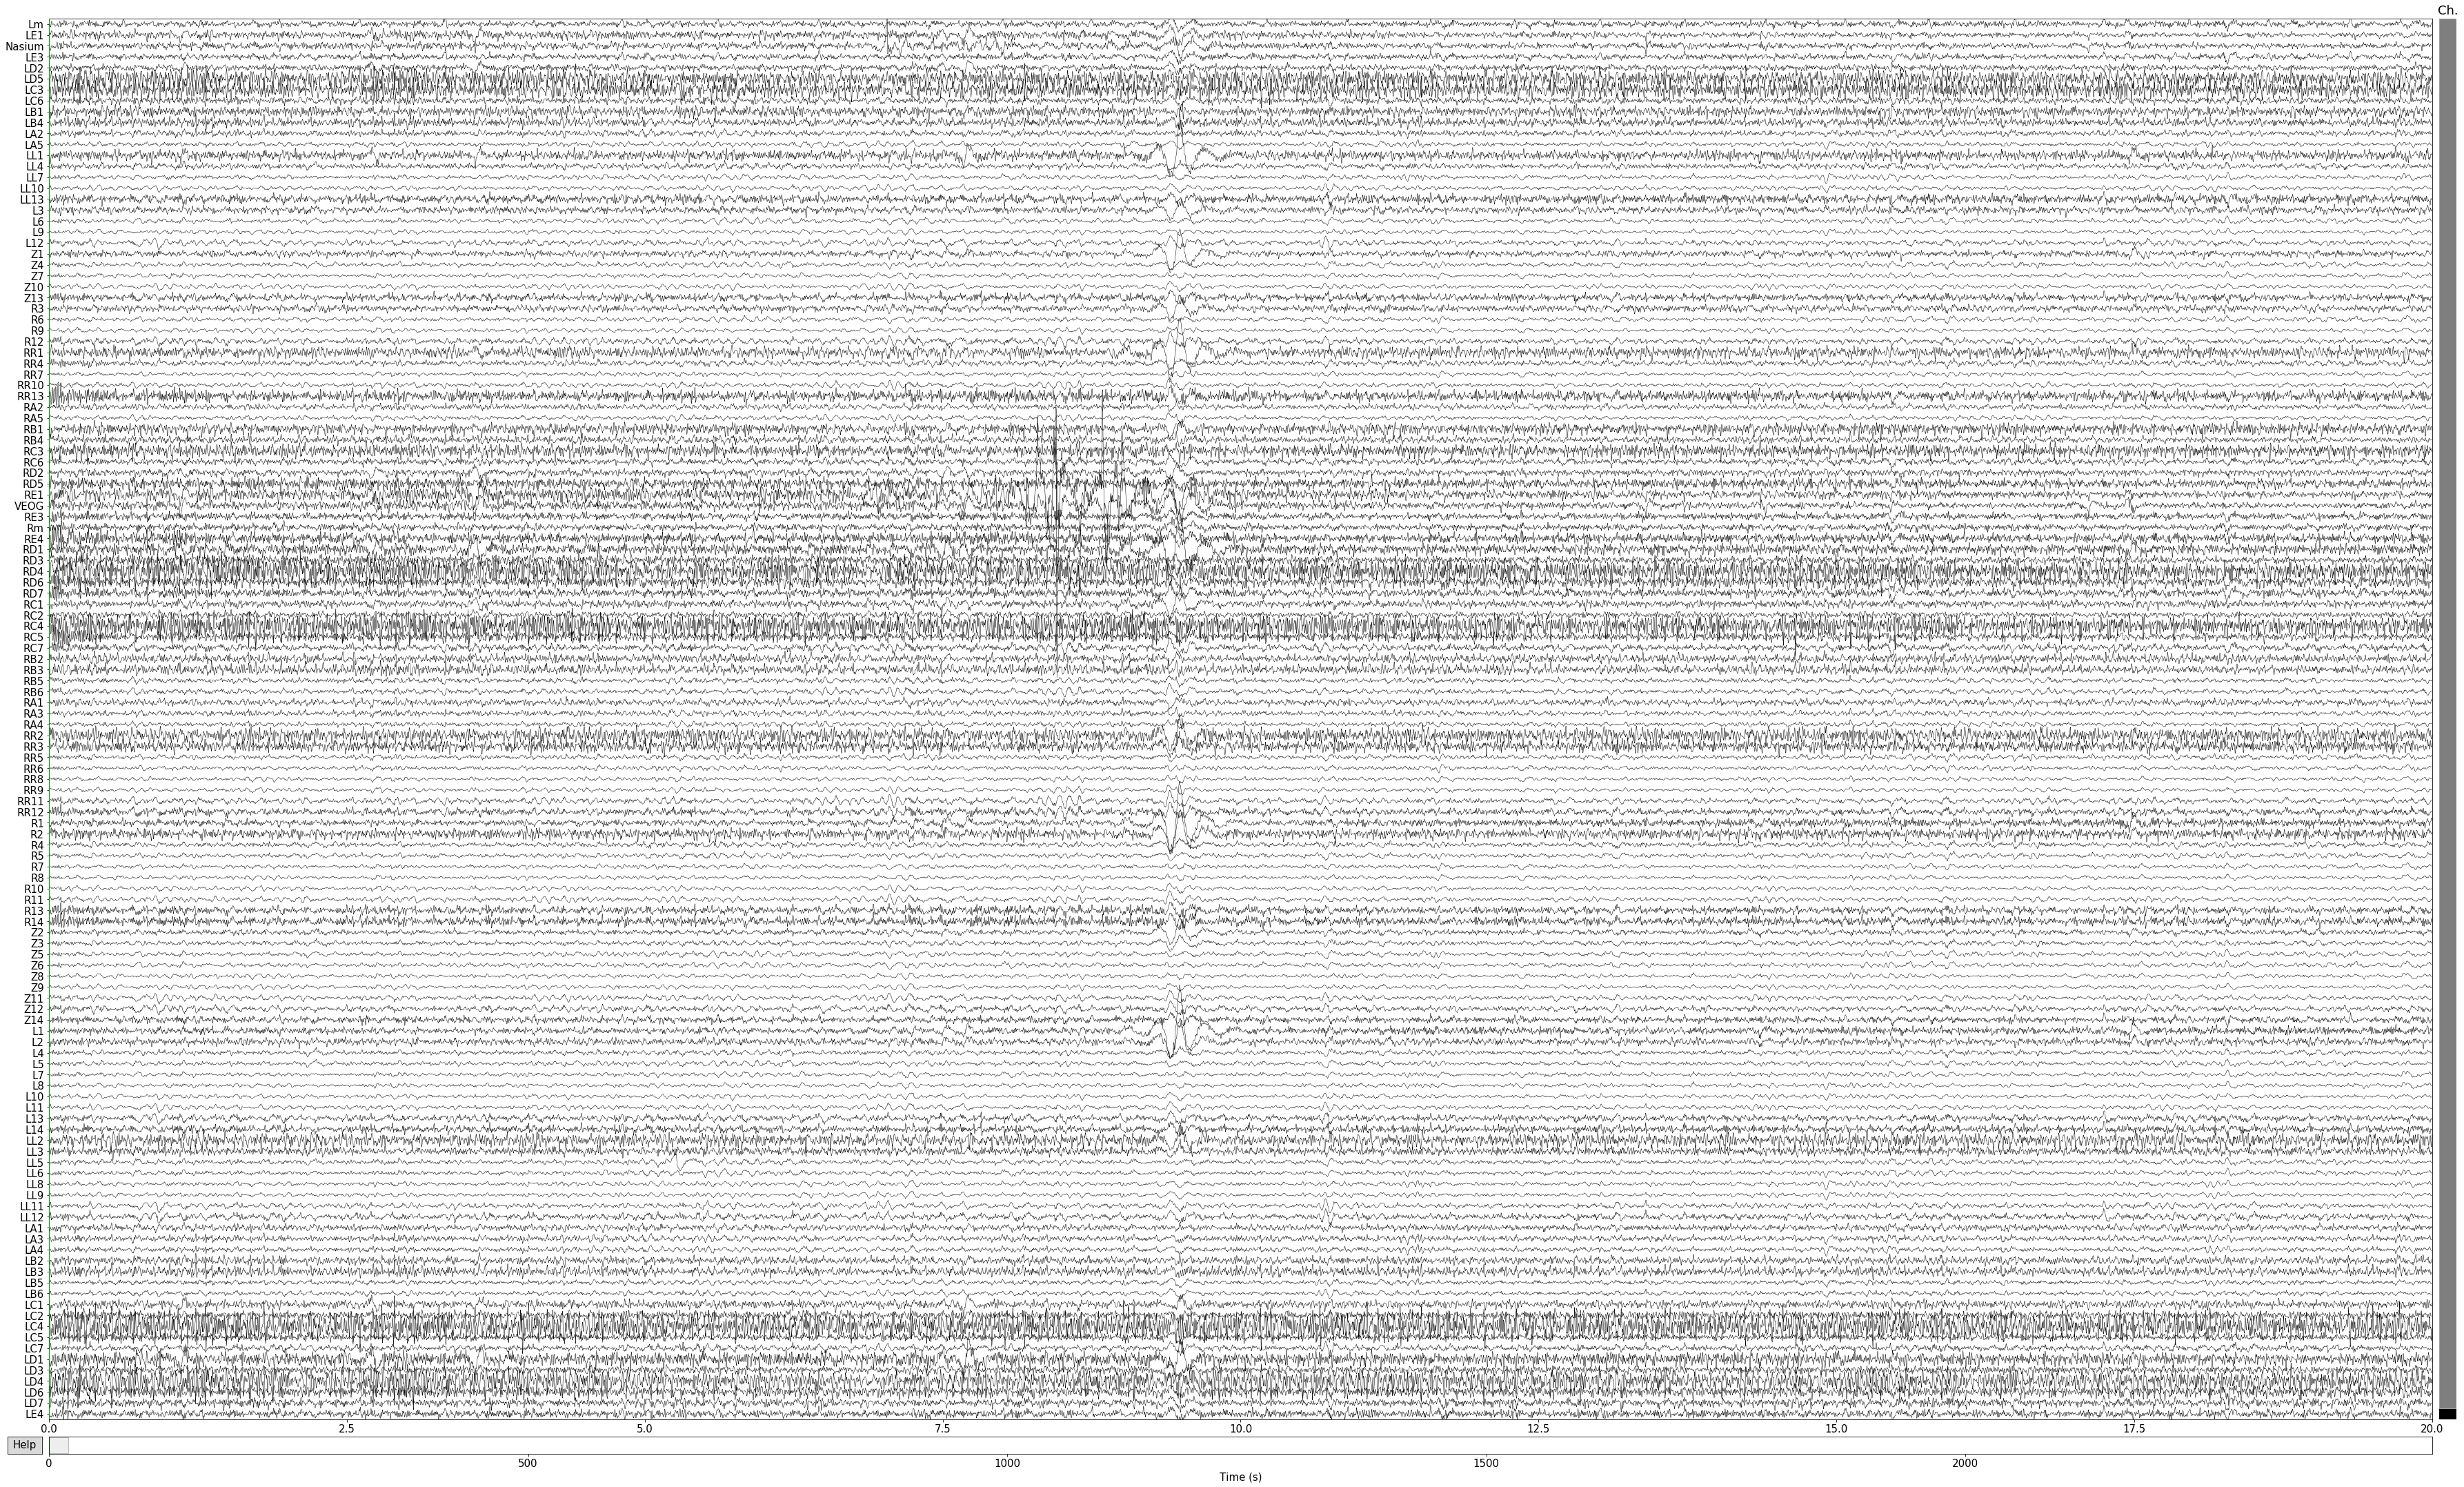

In [27]:
raw_ica.plot(duration=20,  n_channels=128);

In [28]:
m_event = mne.find_events(raw_ica, min_duration=1/raw.info['sfreq'], shortest_event= 0.5, initial_event=True)

7932 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  31 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 155 156 157 158 159 160 161 162 163 164 165]


In [29]:
raw.add_events = m_event

In [30]:
# event_id : this dictionary is created from information from Dave's dissertation page 27
concepts={1:'BABY',2:'BELL',3:'BIRD',4:'BURP',5:'DOG',6:'DRUM',
              7:'KNOCK',8:'LAUGH',9:'PHONE',10:'TRAIN',11:'WATER'}

event_id = {'trail_start':  31, 
            'left_button':  131, 
            'right_button': 132,
            'congruent':    133,
            'incongruent':  134,
            'correct':      129,
            'incorrect':    130,
            # targets
            't_baby' :        135,
            't_bell':         136,
            't_bird':         137,
            't_burp':         138,
            't_dog':          139,
            't_drum':         140,
            't_knock':        141,
            't_laugh':        142,
            't_phone':        143,
            't_train':        144,
            't_water':        145,
            #flankers
            'f_baby' :        155,
            'f_bell':         156,
            'f_bird':         157,
            'f_burp':         158,
            'f_dog':          159,
            'f_drum':         160,
            'f_knock':        161,
            'f_laugh':        162,
            'f_phone':        163,
            'f_train':        164,
            'f_water':        165,
}
# event codes 1 - 24 represent flanker and target stim codes. They are NOT explicity defined in dissertation.
for i in range(1,13):
    event_id["flanker_stim_{0}".format(i)] = i
    
for j in range(13, 25):
    event_id["target_stim_{0}".format(j)] = j

In [31]:
epoch = mne.Epochs(raw_ica, events=m_event, event_id = event_id, preload = True, )

7931 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 7931 events and 359 original time points ...
0 bad epochs dropped


In [32]:
epoch.resample(256);

In [ ]:
# epoch.plot(n_channels=20, n_epochs=20, title="epochs")

### PCA 

In [33]:
from mne.datasets import sample
from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA

In [ ]:
pca = UnsupervisedSpatialFilter(PCA(9), average=False) # PCA, keep 9 components 

epoch_data = epoch.get_data()
pca_data = pca.fit_transform(epoch_data)